# Your First Machine Learning Model - K-means Clustering (Part 1)
Machine learning can sound intimidating, but in simple terms all it really means is that you are using a computer to automate some of the steps involved in building a "model;" and a model is just a simplified representation/abstraction of reality that is useful in understanding and decision-making. In machine learning, models are mathematical/algorithmic constructions that generate predictions or classifications.

In the picture below, the blue dots are the data observations, the dotted black line is the linear model, and the algorithm used to fit that model is least-squares regression.

![linear](https://raw.githubusercontent.com/nanodan/images/master/linear_model.png)

In a "clustering" problem, a human might look at the data, decide on some "natural" grouping based on intuition or analysis, and assign individual observations to each group. They may come up with a set of rules for doing so in a consistent way so that others can replicate their decisions; these rules become the model. A simple example might be to define "unsafe driving" as a driver who has exhibited speeding behaviour of more than 10km/hr over the speed limit for more than 5 minutes. You now have two categories, safe and unsafe driving, and a method by which to assign observations to each "class".

The "machine learning" approach would be to use an algorithm to automatically identify the "best" groupings - in a mathematical sense - and assign each observation to the most appropriate group. The "best" groupings might be something like the series of assignments which produces the highest ratio of inter-group to intra-group distance. In addition to being more reproducible and mathematically rigorous, the machine learning approach is more scalable, and often uncovers novel insights about your data that you might miss through a purely manual analysis. It also becomes essential as your problem complexity increases; it is very hard for a human to visualize and understand high-dimesionality data.

While machine learning is a very powerful tool, an important thing to keep in mind when applying it to your business problems is that there is "no free lunch;" *there is no single approach - or model - that is going to work in every situation*. A machine learning model is a simplified representation of reality, an abstraction, made with certain **assumptions**. As long as these assumptions hold, the model can serve as a reasonable approximation of reality and you can use it to find insight and drive decision-making. When these assumptions are not valid, the answers that you get from your model can lead you astray. This is where domain expertise becomes important; both to craft the inputs to the machine learning model and to assess the reasonableness of the results.

The computer is always going to give you an answer, but it's up to you to make sure that the answer makes sense. It's important to always check your assumptions; machine learning is not a cure-all and it should not be treated as a black box. To uncover value from machine learning approaches requires a thorough understanding of: 

* your data,
* the different possible modelling approaches and their limitations, 
* and the business problem you are trying to solve.

# Introduction to K-means
In this session we will be using a machine learning algorithm called "k-means clustering" to identify candidate locations for distribution centers. 

K-means clustering is an unsupervised algorithm used to find "groups" in numerical data. Unsupervised means that you have data without pre-defined labels or categories and you want to discover them. The user running the algorithm specifies $k$ - the number of "clusters" (groups) - and the algorithm works to minimize the total "distance" from each point to its assigned cluster (i.e. the *mean* of that group of points, hence k-means clustering).

The algorithm starts with randomly seeded clusters (shown in black/red in the left image). These centroids are then moved to the mean position of all assigned points (shown by the arrows in the right image) after which the points are re-assigned to the nearest centroid. This is done iteratively until the centroids have reached a stable position. For those interested, more detailed mathematics of the k-means algorithm can be found at the bottom of this notebook. The shaded regions are a voronoi diagram of the regions within which points would be assigned to the same cluster. You can see that k-means clustering creates linear boundaries between clusters - this is one of the important things to keep in mind when using k-means clustering and interpreting the results.

You can try out k-means on different simple distributions of points and view the results at this link: [k-means visualization](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/). You'll see that some distributions of data are amenable to clustering with this algorithm and some are not.

![k-means steps](https://raw.githubusercontent.com/nanodan/images/master/kmeans_process_Oct7.png)

![k-means clustering](https://raw.githubusercontent.com/nanodan/images/master/kmeans_outcome_Oct7.png)

K-means has certain **assumptions** built into the algorithm. For the results to be valid, these assumptions must be true in the data you are trying to cluster:

* Each cluster is roughly isotropic (i.e. spherical variance)
* All clusters are similar in "spatial" extent (i.e. similar variance along each dimension to every other cluster)
* The prior probability of each cluster is the same (i.e. a similar number of observations exist in each cluster)

You can stray slightly from these assumptions and still get back useful results, but stray too far and the algorithm won't work like you expect it to.

Remember that a computer will only do what you tell it to do. If you tell the algorithm to find 10  clusters, it's going to find 10 mathematically optimized clusters; that doesn't necessarily mean that those 10 clusters are going to be meaningful.

![k-means 10 clusters](https://raw.githubusercontent.com/nanodan/images/master/10clusters_Oct7.png)

# Data Importing and Visualizing
We're now going to import some data to do our first k-means clustering on real-life telematics data. The data provided here is for delivery and collection locations in the Toronto region. Right now our business is operating out of one central location and our trucks are making many deliveries and collections each day across the region.

In [ ]:
#@title Install mapboxgl
%%capture
!pip install mapboxgl

In [ ]:
#@title Imports
from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import branca.colormap
import branca.utilities

from google.colab import auth
from google.cloud import bigquery

from math import radians, cos, sin, asin, sqrt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances

from mapboxgl.viz import CircleViz
from mapboxgl.utils import create_color_stops, df_to_geojson

%matplotlib inline

 In order to access the data, please run the authentication cell, follow the link, copy the code that you receive into the box, and press enter before proceeding

In [ ]:
#@title Authenticate
_ = auth.authenticate_user()

In [ ]:
#@title Client credentials
client = bigquery.Client(project='geotab-bootcamp')
token = 'pk.eyJ1IjoiZGpsZXdpcyIsImEiOiJKbXFqSk1nIn0.xOIh2IXbkqNErTsOQNzxhw'
# token = 'pk.eyJ1IjoiZ2VvdGFiIiwiYSI6ImNrN204dm5oMjAwMzAzZXFyZTB5dXhkenEifQ.OBODYezZooriSoTK4Pu6cQ'

In [ ]:
#@title SQL query to pull data from BigQuery
SQL = """
select DeviceId, Latitude, Longitude
       , StopDuration/60 as StopDurationMin
       , TripDuration, HourStart, HourStop
  from `geotab-bootcamp.DemoData.Deliveries`
 where Distance > 1 
   and StopDuration/60 < 120
   and StopDuration/60 > 10
"""

In [ ]:
#@title Run the query
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False
delivery_df = client.query(SQL, job_config=job_config).to_dataframe()

We've created a dataframe which contains our trip details from our sample dataset which includes things like the duration of each stop and the location.

In [ ]:
delivery_df.head(1)

,DeviceId,Latitude,Longitude,StopDurationMin,TripDuration,HourStart,HourStop
0,847091737,43.761307,-79.46908,53.766667,349,4,5


In [ ]:
#@title Convert the pandas dataframe to a geojson object
delivery_geojson = df_to_geojson(delivery_df, 
                                 lat='Latitude', 
                                 lon='Longitude', 
               
                                 properties=['StopDurationMin', 
                                             'TripDuration', 
                                             'HourStart', 
                                             'HourStop', 
                                             'DeviceId'], 
                                 precision=5)

We're going to now visualize our data on the map below. What do you observe about the deliveries in the region? Are there any natural groupings or clusters that jump out at you?

In [ ]:
viz = CircleViz(delivery_geojson,
                access_token=token,
                height='600px',
                width='1000px',
                radius=3,
                zoom=10,
                color_default='#00aeef',
                stroke_color='black',
                center=(delivery_df['Longitude'].mean(), 
                        delivery_df['Latitude'].mean()),
)
viz.show()

Output hidden; open in https://colab.research.google.com to view.

Let's plot the same map again, but this time we'll colour the points by vehicle ID number, so we can see if we have any patterns in which vehicles are making which deliveries and collections.

In [ ]:
# Categorical
colors = [str(x) for x in branca.utilities.color_brewer('Paired', 12)]
hwids = list(delivery_df['DeviceId'].unique())
color_stops = [[str(x), colors[i]] for i, x in enumerate(hwids)]

viz = CircleViz(delivery_geojson,
                access_token=token,
                height='600px',
                width='1000px',
                radius=3,
                zoom=10,
                color_default='#1f77b4',
                stroke_color='black',
                center=(delivery_df['Longitude'].mean(), 
                        delivery_df['Latitude'].mean()),
                color_function_type='match',
                color_property='DeviceId',
                color_stops=color_stops
)
viz.show()

Output hidden; open in https://colab.research.google.com to view.

Do you observe any patterns in the data? Try plotting some of the other properties too. Is there any lacking information you'd want to include?

In [ ]:
# Continuous
colors = [str(x) for x in branca.utilities.color_brewer('Spectral_r', 7)]
stops = [10, 15, 20, 25, 30, 35, 40]
color_stops = [[x, colors[i]] for i, x in enumerate(stops)]

viz = CircleViz(delivery_geojson,
                access_token=token,
                height='600px',
                width='1000px',
                radius=3,
                zoom=10,
                color_default='#1f77b4',
                stroke_color='black',
                center=(delivery_df['Longitude'].mean(), 
                        delivery_df['Latitude'].mean()),
                color_function_type='interpolate',
                color_property='StopDurationMin',
                color_stops=color_stops
)
viz.show()

Output hidden; open in https://colab.research.google.com to view.

We are thinking that we may be able to save costs on fuel and increase the number of deliveries and collections per day if we add some small distribution centers across the area, in addition to our central headquarters. These will serve as way-points for our vehicles to operate within specific zones throughout the day, reducing the number of long trips back to headquarters.

How would we use k-means to solve this problem and optimize our choice of locations? Why do you think k-means is a good choice here? Can you think of reasons why it might not be a good choice?

# K-means First Attempt

I've provided the code in this section to perform k-means clustering on our delivery location data and visualize the results. Try changing the number of clusters and see what the results look like on the map. Is it what you expected? Do the results make sense? What other information might you want to include rather than just location?

In [ ]:
X = delivery_df[['Latitude', 'Longitude']]

The code in the cell below is all you need to perform k-means clustering. There are really only two lines of code required!

The actual model creation step in machine learning is often (but not always) trivial. Most of the code for common algorithms (e.g. k-means clustering, DBSCAN, hierarchical clustering, random forests, decision trees) has been written into scipy and scikit-learn functions, tensorflow, and similar packages.

The hardest part is typically all of the work required to define the problem in a way that can be solved with machine learning, to prepare and clean the data,  to define and engineer the right "features", and to choose the appropriate algorithm.

Once the hard work is done in preparing your data, the modelling step is often very fast! You may look at the results, and decide they don't make sense, or they aren't good enough, and go back to problem definition and data preparation steps many times, but actually running the model is often trivial. 

To make sense of the results requires a good understanding of the business problem you're trying to solve. In our examples here, think about how you would approach this problem without machine learning. Do you think machine learning makes it easier? What are the advantages and disadvantages?

In [ ]:
#@title Your very first k-means clustering model!
n_clusters = 6 #@param {type:"integer"}
kmn = KMeans(n_clusters=n_clusters, n_jobs=-1)
_ = kmn.fit(X)

The code below will plot your resulting clusters. Each point will have a colour associated with the cluster it has been assigned to. The centroids of these clusters are in black.

In [ ]:
delivery_df['Label'] = kmn.labels_
centers = pd.DataFrame(np.concatenate((kmn.cluster_centers_, 
                                       -1*np.ones((n_clusters, 1))), axis=1), 
                       columns=['Latitude', 'Longitude', 'Label'])
label_data = df_to_geojson(pd.concat([delivery_df[['Latitude', 'Longitude', 
                                                   'Label']], centers], axis=0, 
                                     sort=False), lat='Latitude', 
                           lon='Longitude', properties=['Label'], precision=5)

colors = branca.utilities.color_brewer('Paired', 12)
colors = branca.colormap.LinearColormap(colors, vmin=0, vmax=1)
color_stops = [[x, colors(x/float(n_clusters))[0:7]] for i, x in enumerate(range(0, n_clusters))]

viz_label = CircleViz(label_data,
                      access_token=token,
                      height='600px',
                      width='1400px',
                      radius=3,
                      zoom=9,
                      color_property='Label',
                      color_function_type='match',
                      color_stops=color_stops,
                      color_default='black',
                      stroke_color='black',
                      center=(delivery_df['Longitude'].mean(),
                              delivery_df['Latitude'].mean())
)
viz_label.show()

Zoom in and look around. Examine and think about the clusters we've identified above using our k-means clustering model. Do they seem reasonable to you? Do our clusters satisfy the assumptions of k-means? If not, why, and is this necessarily a problem for this particular application? Would you put distribution centers in these locations? Why or why not? What additional information is missing, and how would you add this information into the model? 

# How to Choose k

After trying out different numbers of clusters above, how would you take the next step and choose the "right" number of clusters. If the algorithm can find any number of clusters for us, what's the "right" answer? There are two ways to think about this. One is from the perspective of the business problem you are solving, and the other is mathematical.

1.   Choose the number of clusters that makes sense for what you're trying to accomplish
2.   Choose the mathematically optimal number of clusters

Whether option (1) or option (2) is the "correct" approach depends on the particular problem. Let's say you have a problem where you want to segment your customers into two types or categories. Then your choice of $k$ would be two, regardless of any other considerations. However, if we think back to our example in the introduction, would two clusters make sense in that data? There are clearly three distinct groups in that data, so by only using two clusters, we'll be losing out on potentially valuable information about the types of customers that we have. Maybe that is okay; it depends on the problem you're trying to solve. 

In the case of distribution centers, if we have already decided we want three distribution centers, then the problem simply becomes the optimal location for each of the three distribution centers, and we don't need to worry about choosing k; it's been chosen for us by our problem definition.

In many problems though, you aren't going to know the right number of clusters. We need to figure out how to determine the right number of clusters in some objective way. This is especially true for problems with more than two dimensions where it isn't always easy to visualize our data.

Let's say that we don't know how many distribution centers we need, and want to figure out what the "right" number is based on how our data is clustered.

There are different ways to do this with their own pros and cons, but the most straightforward approach is to use an "elbow" plot, which you'll see below.

In [ ]:
#@title Calculating SSE for k=1 to 16
sse = []
for k in range(1, 17):
    kmn = KMeans(n_clusters=k, n_jobs=-1)
    _ = kmn.fit(X)
    sse.append(kmn.inertia_)

In [ ]:
#@title Generating a normalized SSE for each k
sse_v = np.dot(1, sse/max(sse))
coords = np.array([range(1, 17), sse_v]).transpose()
p1, p2 = coords[0], coords[-1]
d = np.cross(p2 - p1, p1 - coords)/np.linalg.norm(p2 - p1)
furthest = coords[d.argmax()]
cmap = branca.colormap.LinearColormap(branca.utilities.color_brewer('YlGnBu', 9), vmin=d.min(), vmax=d.max())

In [ ]:
#@title Elbow Plot Function
def distance_plot(dist, coords, d, furthest, cmap, rangemax):
    sns.set(style='whitegrid')
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    _ = ax.plot(range(1, rangemax), dist, 'kx-', zorder=4)
    _ = ax.plot([1, rangemax-1], [dist[0], dist[-1]], 'r')
    
    x1 = coords[0][0]
    x2 = coords[-1][0]
    y1 = coords[0][1]
    y2 = coords[-1][1]
    m1 = (y2 - y1)/(x2 - x1)
    b1 = y1 - m1*x1
    m2 = -1/m1
    b2 = []
    colors = []
    
    for n in range(2, rangemax-1):
        x3 = n
        y3 = coords[n-1][1]
        b2.append(y3 - m2*x3)
        colors.append(cmap(d[n-1]))

    for n in range(0, len(b2)):
        _ = ax.plot([n+2, (b2[n]-b1)/(m1-m2)], [(n+2)*m2 + b2[n], ((b2[n]-b1)/(m1-m2))*m2 + b2[n]], c=colors[n], linestyle='-.', linewidth=3, zorder=3)

    _ = ax.scatter([furthest[0]], [furthest[1]], c='k', s=300, zorder=5)
    _ = ax.set_xlim([0, rangemax])
    _ = ax.set_xticks(np.arange(0, rangemax, 1))
    _ = ax.set_ylim([0, 1.05])
    _ = ax.set_xlabel('Number of Clusters')
    _ = ax.set_ylabel('K-means SSE')
    _ = ax.set_title('K-means Elbow Point for Optimal Clusters')
    
    return ax

In the code above, we ran k-means multiple times for k ranging from 1 to 16, and calculated the total sum of square errors (SSE) for each k. This is just a more precise way of saying we added up all the squared distances from our data points to their assigned centroids.

If we plot the SSE vs. the number of clusters, what we will see is a decreasing SSE as we increase the number of clusters. Now, keep in mind that adding more clusters will *always* decrease the SSE (think about why), so we need to decide where to stop; where the number of clusters is "good enough" to partition the data, and that we don't gain much more useful information - or do a better job - by adding more clusters.

This is what you may call the point of diminishing returns, and it is the "elbow" of the plot. You can identify this point visually, or you can select it mathematically by creating a line from the highest to lowest SSE and finding the point of the curve that is furthest from this line, as shown below.

There are other more advanced techniques such as the gap statistic, and silhouette score, which can be combined with the elbow-plot method. I encourage you to read more about these if you are thinking about applying k-means clustering to your own business problems.

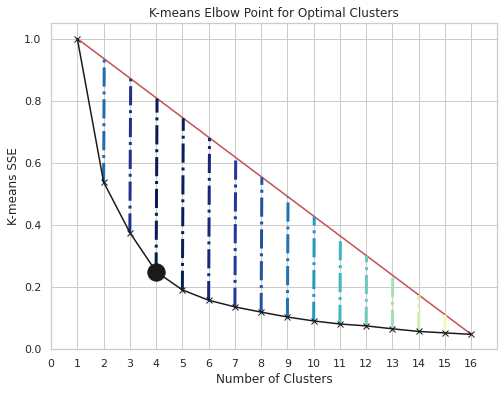

In [ ]:
distance_plot(sse_v, coords, d, furthest, cmap, 17)

For our data, it seems that the mathematically optimal number of distribution centers is 4, maybe 5 clusters. Let's re-run k-means clustering again with 4 clusters and visualize the results.

In [ ]:
n_clusters = 4 #@param {type:"integer"}
kmn = KMeans(n_clusters=n_clusters)
_ = kmn.fit(X)

In [ ]:
delivery_df['Label'] = kmn.labels_
centers = pd.DataFrame(np.concatenate((kmn.cluster_centers_, 
                                       -1*np.ones((n_clusters, 1))), axis=1), 
                       columns=['Latitude', 'Longitude', 'Label'])
label_data = df_to_geojson(pd.concat([delivery_df[['Latitude', 'Longitude', 
                                                   'Label']], centers], axis=0,
                                     sort=False), lat='Latitude', 
                           lon='Longitude', properties=['Label'], precision=5)
colors = branca.utilities.color_brewer('Paired', 12)
color_stops = [[x, str(colors[i])] for i, x in enumerate(range(0, n_clusters))]
viz_label = CircleViz(label_data,
                      access_token=token,
                      height='600px',
                      width='1000px',
                      radius=3,
                      zoom=10,
                      color_property='Label',
                      color_function_type='match',
                      color_stops=color_stops,
                      color_default='black',
                      stroke_color='black',
                      center=(delivery_df['Longitude'].mean(), 
                              delivery_df['Latitude'].mean())
)
viz_label.show()

Based on our data, there are naturally 4-5 clusters or regions in where we make our deliveries. Do these make sense to you? What other information might we want to include to further refine our choice of distribution center?

Do our clusters violate the assumptions of k-means? If so, is it a problem for this application?

If you zoom into the map, particularly in downtown Toronto, you'll see we have a lot of deliveries/collections in very close proximity. These are likely repeats to the same customer. What if we want to only consider each customer once in determining where to put our distribution centers. Does this approach make sense? Why or why not?

The rest of this notebook shows how you might use the DBSCAN algorithm to reduce the data by combining locations into "zones", prior to k-means clustering.

If you want to jump ahead and try a more complicated example of using k-means clustering on higher-dimensional data, then open part 2 now.

# Data Reduction

In this section we'll be using the DBSCAN algorithm to pre-cluster our data into "zones" prior to k-means clustering. DBSCAN stands for *Density Based Spatial Clustering of Applications with Noise*. It differs from k-means clustering in a number of ways. When using DBSCAN, you don't have to specify the number of clusters; you instead specify a distance parameter, and all points which are linked to each other by less than this distance become part of a cluster. This is illustrated visually below, where the red and yellow points are part of the same cluster. The red points are core points of that cluster (connected to more than one other point). The yellow points are not core points, but still belong to the cluster, while the blue point is a separate cluster.

![dbscan](https://raw.githubusercontent.com/nanodan/images/master/500px-DBSCAN-Illustration.svg.png)
![dbscan-2](https://raw.githubusercontent.com/nanodan/images/master/488px-DBSCAN-density-data.svg.png)

DBSCAN does not have the same assumptions as k-means clustering. It can easily find anisotropic clusters and can be made robust to outliers by setting a minimum number of points per cluster. However, it is not well suited to problems which have clusters of varying spatial density and suffers from the same curse of dimensionality as k-means.

We'll use the haversine distance between points as our distance metric for DBSCAN so that we can specify a search radius in meters. The haversine distance is just a formula which takes into account the curvature of the earth, which is necessary when calculating the distance between points that are far apart.

In [ ]:
#@title Haversine Distance
def haversine(p1, p2):
    lat1, lon1 = p1[0], p1[1]
    lat2, lon2 = p2[0], p2[1]
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378137.0
    return c * r

Because DBSCAN requires a pairwise computation of distance between every point, the runtime complexity is $\mathcal{O}(n^2)$. Unlike k-means, there are no heuristics we can use to shorten the runtime and thus DBSCAN becomes very slow for large numbers of points. To illustrate the concept I'll take a small sample of our data. You can try increasing the sample size after, and compare the results.

In [ ]:
sample_size = 2000 #@param {type:"integer"}
df_sample = delivery_df[['Latitude', 'Longitude']].sample(sample_size)
data_sample = df_to_geojson(df_sample, lat='Latitude', lon='Longitude', precision=5)

In [ ]:
%%time
distances = pairwise_distances(df_sample, Y=None, metric=haversine, n_jobs=1)

CPU times: user 9.58 s, sys: 8.9 ms, total: 9.59 s
Wall time: 9.6 s


The two lines of code below are all that is required to run DBSCAN on our data. The $eps$ parameter is the distance parameter (the radius in the above diagrams). Because we've defined our haversine distance function in meters, this is the radius from each point in meters that another point has to be within to count towards the same cluster. Try changing the distance parameter and see how it affects the resulting number of clusters.

In [ ]:
dist = 100 #@param {type:"integer"}
dbscn = DBSCAN(eps=dist, min_samples=1, metric='precomputed')
_ = dbscn.fit(distances)

In [ ]:
print("DBSCAN identified", len(set(dbscn.labels_)), "clusters from", sample_size, "points")

DBSCAN identified 422 clusters from 2000 points


In the next step, I perform a group by to get the average of all points assigned to a cluster and then visualize these positions. Note that because DBSCAN doesn't necessarily produce isotropic clusters, that the centroid doesn't hold the same meaning as it might with k-means clustering. In the second map below, I show an example of the points which comprise a few of the identified clusters.

In [ ]:
df_sample['Label'] = dbscn.labels_
df_sample_gg = df_sample.groupby(by=['Label'], as_index=False).mean()
data_sample = df_to_geojson(df_sample_gg, lat='Latitude', lon='Longitude', properties=['Label'], precision=5)

In [ ]:
sample_viz = CircleViz(data_sample,
                access_token=token,
                height='600px',
                width='1000px',
                radius=3,
                zoom=10,
                color_default='#00aeef',
                stroke_color='black',
                center=(df_sample['Longitude'].mean(), df_sample['Latitude'].mean()),
              )
sample_viz.show()

In [ ]:
data_sample = df_to_geojson(df_sample[df_sample['Label'].isin([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])], lat='Latitude', lon='Longitude', properties=['Label'], precision=5)
colors = branca.utilities.color_brewer('Paired', 12)
color_stops = [[x, str(colors[i])] for i, x in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])]
viz_label = CircleViz(data_sample,
                      access_token=token,
                      height='600px',
                      width='1000px',
                      radius=3,
                      zoom=10,
                      color_property='Label',
                      color_function_type='match',
                      color_stops=color_stops,
                      color_default='black',
                      stroke_color='black',
                      center=(df_sample['Longitude'].mean(), df_sample['Latitude'].mean())
)
viz_label.show()

How do these groupings look to you? Are they too small, too big? We could increase and decrease the distance parameter as we see fit, to try and make sure we have one customer per cluster, or we can intentionally include multiple customers per cluster. A lot of these type of nuances ultimately depend on how you want to approach the business problem at hand.

# Clustering Reduced Data
Once you're happy with the resulting data reduction from DBSCAN, we'll go ahead and perform k-means clustering again on the reduced dataset. We'll group by the cluster label, taking the mean position of each of the points assigned to the cluster. This will be our new input data for k-means.

In [ ]:
sse = []
for k in range(1, 17):
    kmn = KMeans(n_clusters=k, n_jobs=-1)
    _ = kmn.fit(df_sample_gg[['Latitude', 'Longitude']].values)
    sse.append(kmn.inertia_)
    
sse_v = np.dot(1, sse/max(sse))
coords = np.array([range(1, 17), sse_v]).transpose()
p1, p2 = coords[0], coords[-1]
d = np.cross(p2 - p1, p1 - coords)/np.linalg.norm(p2 - p1)
furthest = coords[d.argmax()]

cmap = branca.colormap.LinearColormap(branca.utilities.color_brewer('YlGnBu', 9), vmin=d.min(), vmax=d.max())

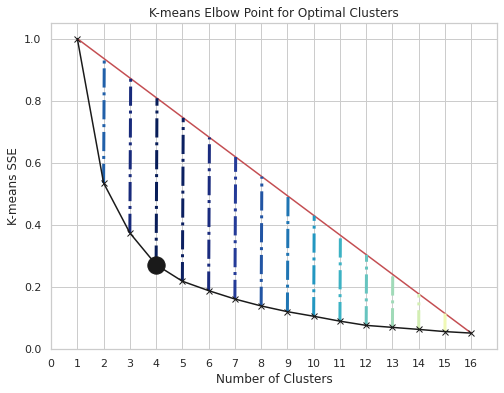

In [ ]:
distance_plot(sse_v, coords, d, furthest, cmap, 17)

It looks like we still have 4-5 optimal clusters, the same as before! Let's try 5 and see how it looks.

In [ ]:
n_clusters = 4 #@param {type:"integer"}
kmn = KMeans(n_clusters=n_clusters)
_ = kmn.fit(df_sample_gg[['Latitude', 'Longitude']])

In [ ]:
df_sample_gg['Label'] = kmn.labels_
centers = pd.DataFrame(np.concatenate((kmn.cluster_centers_, -1*np.ones((n_clusters, 1))), axis=1), columns=['Latitude', 'Longitude', 'Label'])
label_data = df_to_geojson(pd.concat([df_sample_gg[['Latitude', 'Longitude', 'Label']], centers], axis=0, sort=False), lat='Latitude', lon='Longitude', properties=['Label'], precision=5)

In [ ]:
colors = branca.utilities.color_brewer('Paired', 12)
color_stops = [[x, str(colors[i])] for i, x in enumerate(range(0, n_clusters))]

In [ ]:
viz_label = CircleViz(label_data,
                      access_token=token,
                      height='600px',
                      width='1000px',
                      radius=3,
                      zoom=10,
                      color_property='Label',
                      color_function_type='match',
                      color_stops=color_stops,
                      color_default='black',
                      stroke_color='black',
                      center=(delivery_df['Longitude'].mean(), delivery_df['Latitude'].mean())
)
viz_label.show()

You might notice some oddities and/or outliers in this map. Or maybe not. Because our sample size was small, we maybe have not created a representative sample. 

Try increasing the number of points in the sampling step and re-run the process a few times to see the difference that sample number can have on the results. It's important to keep in mind the sample size when doing machine learning on your data. In general, the more data you have the more accurate your results will be as you are more likely to be working with a sample which more accurately reflects the underlying population. As you reduce your sample size, you increase the liklihood of having a biased sample which may not generalize well, or may lead you to false conclusions.

# Supplemental: K-means Algorithm
K-means clustering is an algorithm which partitions $n$ observations into $k$ clusters where each observation belongs to the cluster with the nearest mean. The number of clusters $k$ is specified. K-means tends to find clusters of similar _spatial_ extent and of isotropic distribution. The general assumptions for a valid application of k-means are: roughly similar cluster sizes (spatially, not in cardinality, i.e. similar variance), and isotropic clusters (spherical variance). Note that since $k$ is specified as part of the algorithm, the results will be meaningless with an inappropriate selection of $k$. For k-means clustering at scale, an appropriate automatic selection of $k$ thus becomes essential.

Given a set of observations $(x_1, x_2, ..., x_n)$, where each observation is a $d$-dimensional vector in Euclidean space, the algorithm seeks to partition the $n$ observations into $k\:(\leq n)$ sets $\mathbf S = \{S_1,S_2,...,S_k\}$ to minimize the total within-cluster sum-of-square error. This is represented as:
$$\underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^{k} \sum_{\mathbf x \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2$$
Where $\boldsymbol \mu_i$ is the mean of all points assigned to cluster $S_i$.

The initial set of $k$ means $m_1^{(1)},...,m_k^{(1)}$ are typically set by choosing a random selection of $k$ points from the dataset. Then all observations are assigned to the nearest mean (i.e. the least squared Euclidean distance), creating a Voronoi diagram.
$$S_i^{(t)} = \big \{ x_p : \big \| x_p - m^{(t)}_i \big \|^2 \le \big \| x_p - m^{(t)}_j \big \|^2 \ \forall j, 1 \le j \le k \big\}$$

After assignment, new means (centroids) are calculated based on the set of observations assigned to each cluster.
$$m^{(t+1)}_i = \frac{1}{|S^{(t)}_i|} \sum_{x_j \in S^{(t)}_i} x_j$$

The procedure is repeated until convergence, where convergence is defined by either identical centroids from one step to the next or a difference in subsequent centroid positions below a specified error tolerance. The algorithm may converge to local optima and is not guaranteed to be globally optimum. Note that the "normal" version of k-means clustering is only defined for Euclidean distance as the distance metric; the centroid of a collection of points is inherently a Euclidean concept. Other distance metrics may not produce convergence.